In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import torch
from kan import *
from kan.KAN import KAN
import sympy as sp
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
device = 'cuda'

In [17]:
from dataloader import preprocess_data, construct_datasets

In [18]:
# split the data into training and testing
train_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_600min.csv'))
val_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_300min.csv'))
test_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_180min.csv'))

creep_data = preprocess_data(pd.read_csv(r'..\dat\creep\random_walk_30min_pause30at30min_15.csv'))

columns_input = ['finestep', 'step_diff', 'step_60rsum_exp', 'step_300rsum_exp', 'c_mean_lag10', 'c_mean_10rmean']
X_train, y_train, X_val, y_val, X_test, y_test = construct_datasets(train_data, val_data, test_data, columns_input)

X_creep = creep_data[columns_input]
y_creep = creep_data['c_mean']

dataset = {}
dataset['train_input'] = torch.tensor(X_train.values, dtype=torch.float32).to(device)
dataset['train_label'] = torch.tensor(y_train.values, dtype=torch.float32).to(device)
dataset['test_input'] = torch.tensor(X_val.values, dtype=torch.float32).to(device)
dataset['test_label'] = torch.tensor(y_val.values, dtype=torch.float32).to(device)
dataset['creep_input'] = torch.tensor(X_creep.values, dtype=torch.float32).to(device)
dataset['creep_label'] = torch.tensor(y_creep.values, dtype=torch.float32).to(device)

#### Optuna

In [1]:
import optuna
from optuna.trial import TrialState

def define_model(trial):
    l_0 = trial.suggest_int("", 1, 3)
    model = KAN(width=[len(columns_input),l_0,1], grid=5, k=3, seed=0, device=device)
    return model

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "LBFGS"])
    result = model.train(dataset, opt=optimizer_name, steps=20, lamb=0.01, lamb_entropy=10., device=device)
    test_loss = result['test_loss']


    return test_loss

c:\Users\David\miniforge3\envs\fp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=600)
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Regular

train loss: 6.17e-02 | test loss: 6.01e-02 | reg: 1.20e+00 : 100%|██| 20/20 [00:13<00:00,  1.49it/s]


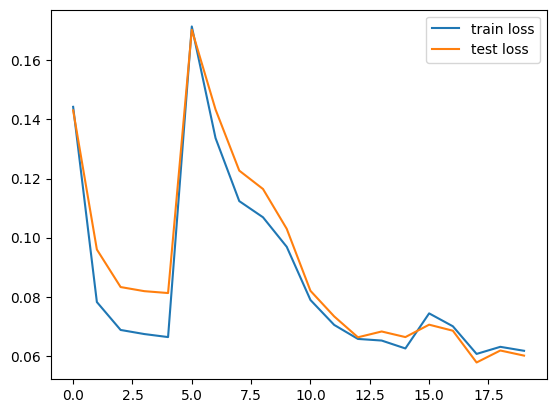

In [34]:
model = KAN(width=[len(X_train.columns),1,1], grid=5, k=3, seed=0, device=device)
result = model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10., device=device)
plt.plot(result['train_loss'], label='train loss')
plt.plot(result['test_loss'], label='test loss')
plt.legend()
plt.show()

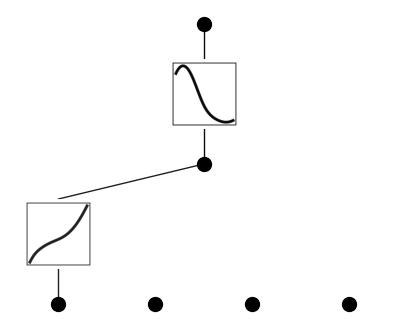

In [35]:
model = model.prune()
model(dataset['train_input'])
model.plot()

train loss: 3.23e-02 | test loss: 3.29e-02 | reg: 2.12e+00 : 100%|██| 20/20 [00:12<00:00,  1.55it/s]


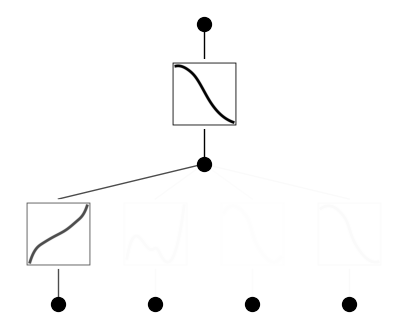

In [36]:
result = model.train(dataset, opt="LBFGS", steps=20, device=device)
model.plot()

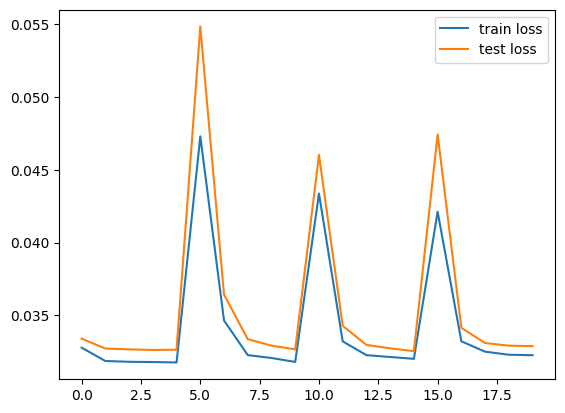

In [37]:
plt.plot(result['train_loss'], label='train loss')
plt.plot(result['test_loss'], label='test loss')
plt.legend()
plt.show()

In [38]:
model2 = KAN(width=[len(X_train.columns),1,1], grid=10, k=3, seed=0, device=device)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input'])

KAN(
  (biases): ModuleList(
    (0-1): 2 x Linear(in_features=1, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

train loss: 3.18e-02 | test loss: 3.25e-02 | reg: 2.45e+00 : 100%|██| 20/20 [00:14<00:00,  1.41it/s]


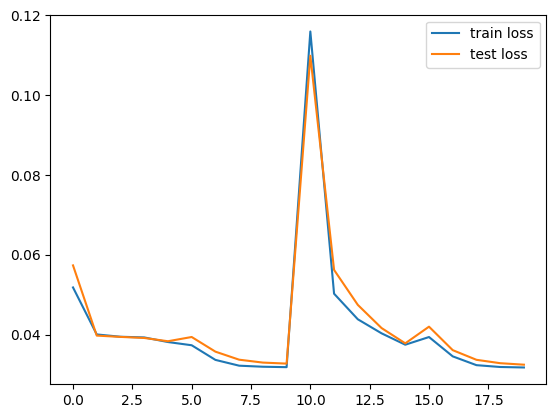

In [40]:
result = model2.train(dataset, opt="LBFGS", steps=20, device=device)
plt.plot(result['train_loss'], label='train loss')
plt.plot(result['test_loss'], label='test loss')
plt.legend()
plt.show()

In [5]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[len(X_train.columns),1,1], grid=grids[i], k=k, seed=0, device=device)
    if i != 0:
        model = KAN(width=[len(X_train.columns),1,1], grid=grids[i], k=k, device=device).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30, device=device)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
model.save_ckpt('model.ckpt')

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

train loss: 3.14e-03 | test loss: 3.22e-03 | reg: 4.57e+00 : 100%|██| 50/50 [00:38<00:00,  1.31it/s]
train loss: 3.12e-03 | test loss: 3.20e-03 | reg: 2.72e+00 : 100%|██| 50/50 [00:40<00:00,  1.23it/s]
train loss: 3.11e-03 | test loss: 3.18e-03 | reg: 2.31e+00 : 100%|██| 50/50 [00:51<00:00,  1.02s/it]
train loss: 3.08e-03 | test loss: 3.17e-03 | reg: 1.57e+00 : 100%|██| 50/50 [01:28<00:00,  1.76s/it]
train loss: 3.07e-03 | test loss: 3.17e-03 | reg: 2.14e+00 : 100%|██| 50/50 [02:48<00:00,  3.37s/it]

save this model to ./model_ckpt/model.ckpt


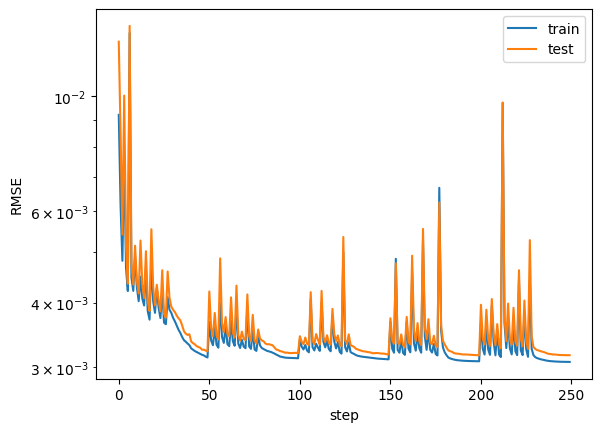

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [4]:
model = KAN(width=[len(X_train.columns),1,1], grid=100, k=3, seed=0, device=device)
model.load_ckpt('model.ckpt')
model(dataset['train_input'])

tensor([[0.4566],
        [0.4561],
        [0.4562],
        ...,
        [0.3172],
        [0.3175],
        [0.3178]], device='cuda:0', grad_fn=<AddBackward0>)

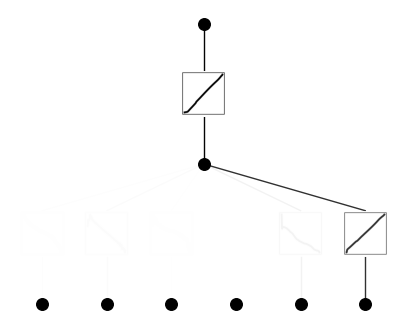

In [5]:
#model = model.prune()
model(dataset['train_input'])
model.plot()

#### Evaluate Model for Hysteresis

MAE: 0.00249824268953361


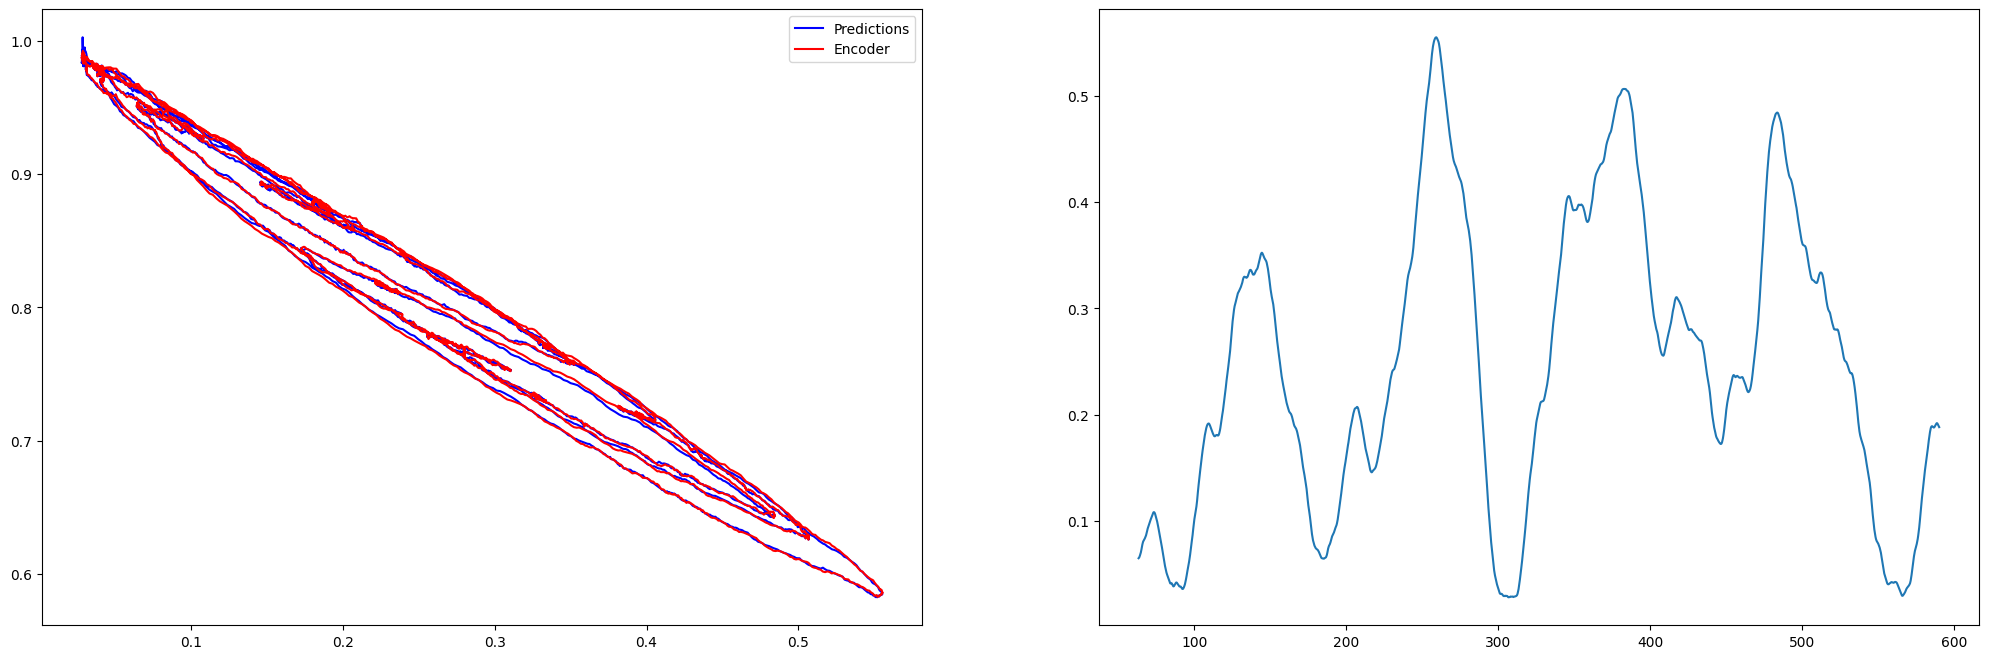

In [23]:
predictions = model(torch.tensor(X_test.values, dtype=torch.float32).to(device)).detach().cpu().numpy()
g_truth = y_test.values
mae = np.mean(np.abs(predictions - g_truth))
print(f'MAE: {mae}')

max_samples = 5000

fig, ax = plt.subplots(1, 2, figsize=(25, 8))
#ax[0].plot(test_df['finestep'], -test_df['c_mean'].rolling(8, center=True).mean())
ax[0].plot(test_data[:max_samples]['finestep'], predictions[:max_samples], label='Predictions', color='blue')
ax[0].plot(test_data[:max_samples]['finestep'], test_data[:max_samples]['c_mean'].rolling(8, center=True).mean(), color='red', label='Encoder')
ax[0].legend()
# mark the start and end of the walk
#ax[0].plot(test_df['finestep'].iloc[0], -test_df['c_mean'].iloc[0], 'ro')
#ax[0].plot(test_df['finestep'].iloc[-1], -test_df['c_mean'].iloc[-1], 'ro')
#ax[0].set_xlim(-np.power(2, 15), np.power(2, 15))
#ax[0].set_ylim(max(outputs), min(outputs) - 0.2)

ax[1].plot(test_data[:max_samples]['time'], test_data[:max_samples]['finestep'])
#ax[1].set_ylim(-np.power(2, 15), np.power(2, 15))

plt.show()




In [11]:
df = pd.read_csv(r'..\dat\hysteresis\hysteresis_display.csv')
test_df = preprocess_data(df)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    predictions = np.array([])
    for index, row in tqdm(test_df.loc[:].iterrows(), total=test_df.shape[0]):
        if len(predictions) > 17000:
            row['c_mean_lag1'] = predictions[-1]
            row['c_mean_60rmean'] = (row['c_mean_60rmean'] * 60 - row['c_mean'] + predictions[-1]) / 60
            row['c_mean_10rmean'] = (row['c_mean_10rmean'] * 10 - row['c_mean'] + predictions[-1]) / 10
            if len(predictions) > 17004:
                row['c_mean_lag5'] = predictions[-5]
            if len(predictions) > 17009:
                row['c_mean_lag10'] = predictions[-10]
            if len(predictions) > 17049:
                row['c_mean_lag50'] = predictions[-50]

        inputs = torch.tensor(row[columns_input].values.astype(float), dtype=torch.float32).view(1, -1).to(device)
        predictions = np.append(predictions, model(inputs).cpu().detach().numpy())

        

100%|██████████| 15784/15784 [01:09<00:00, 226.84it/s]


In [13]:
df = pd.read_csv(r'..\dat\hysteresis\hysteresis_display.csv')
test_df = preprocess_data(df)

predictions = model(torch.tensor(test_df[columns_input].values, dtype=torch.float32).to(device)).detach().cpu().numpy()

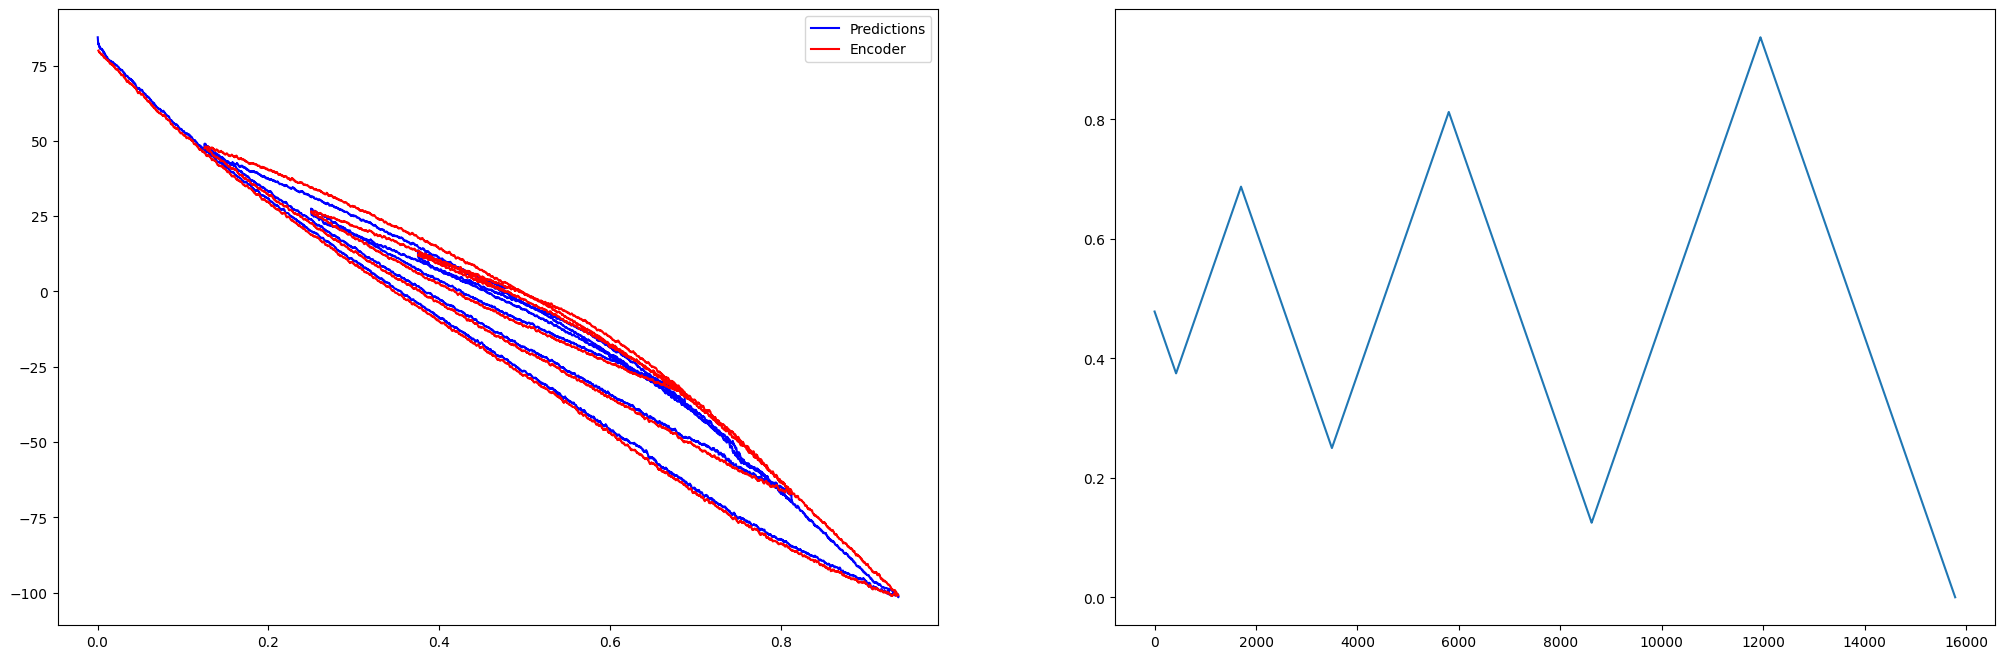

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
outputs_unnorm = np.array(predictions) * (df['counter'].max() - df['counter'].min()) + df['counter'].min()
#ax[0].plot(test_df['finestep'], -test_df['c_mean'].rolling(8, center=True).mean())
ax[0].plot(df['finestep'], outputs_unnorm, label='Predictions', color='blue')
ax[0].plot(df['finestep'], df['counter'].rolling(8, center=True).mean(), color='red', label='Encoder')
ax[0].legend()
# mark the start and end of the walk
#ax[0].plot(test_df['finestep'].iloc[0], -test_df['c_mean'].iloc[0], 'ro')
#ax[0].plot(test_df['finestep'].iloc[-1], -test_df['c_mean'].iloc[-1], 'ro')
#ax[0].set_xlim(-np.power(2, 15), np.power(2, 15))
#ax[0].set_ylim(max(outputs), min(outputs) - 0.2)

ax[1].plot(df['finestep'])
#ax[1].set_ylim(-np.power(2, 15), np.power(2, 15))

plt.show()

#### Evaluate Model for Creep

In [19]:
import warnings
from tqdm import tqdm
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    predictions = np.array([])
    for index, row in tqdm(creep_data.loc[:].iterrows(), total=creep_data.shape[0]):
        if len(predictions) > 17000:
            row['c_mean_lag1'] = predictions[-1]
            row['c_mean_60rmean'] = (row['c_mean_60rmean'] * 60 - row['c_mean'] + predictions[-1]) / 60
            row['c_mean_10rmean'] = (row['c_mean_10rmean'] * 10 - row['c_mean'] + predictions[-1]) / 10
            if len(predictions) > 17004:
                row['c_mean_lag5'] = predictions[-5]
            if len(predictions) > 17009:
                row['c_mean_lag10'] = predictions[-10]
            if len(predictions) > 17049:
                row['c_mean_lag50'] = predictions[-50]

        inputs = torch.tensor(row[columns_input].values, dtype=torch.float32).view(1, -1).to(device)
        predictions = np.append(predictions, model(inputs).cpu().detach().numpy())

100%|██████████| 35274/35274 [05:37<00:00, 104.64it/s]


In [24]:
mae = np.mean(np.abs(predictions - creep_data['c_mean'].values))
print(f'MAE: {mae}')
mse = np.mean(np.square(predictions - creep_data['c_mean'].values))
print(f'MSE: {mse}')

MAE: 0.002609945142846379
MSE: 1.0904616352412663e-05


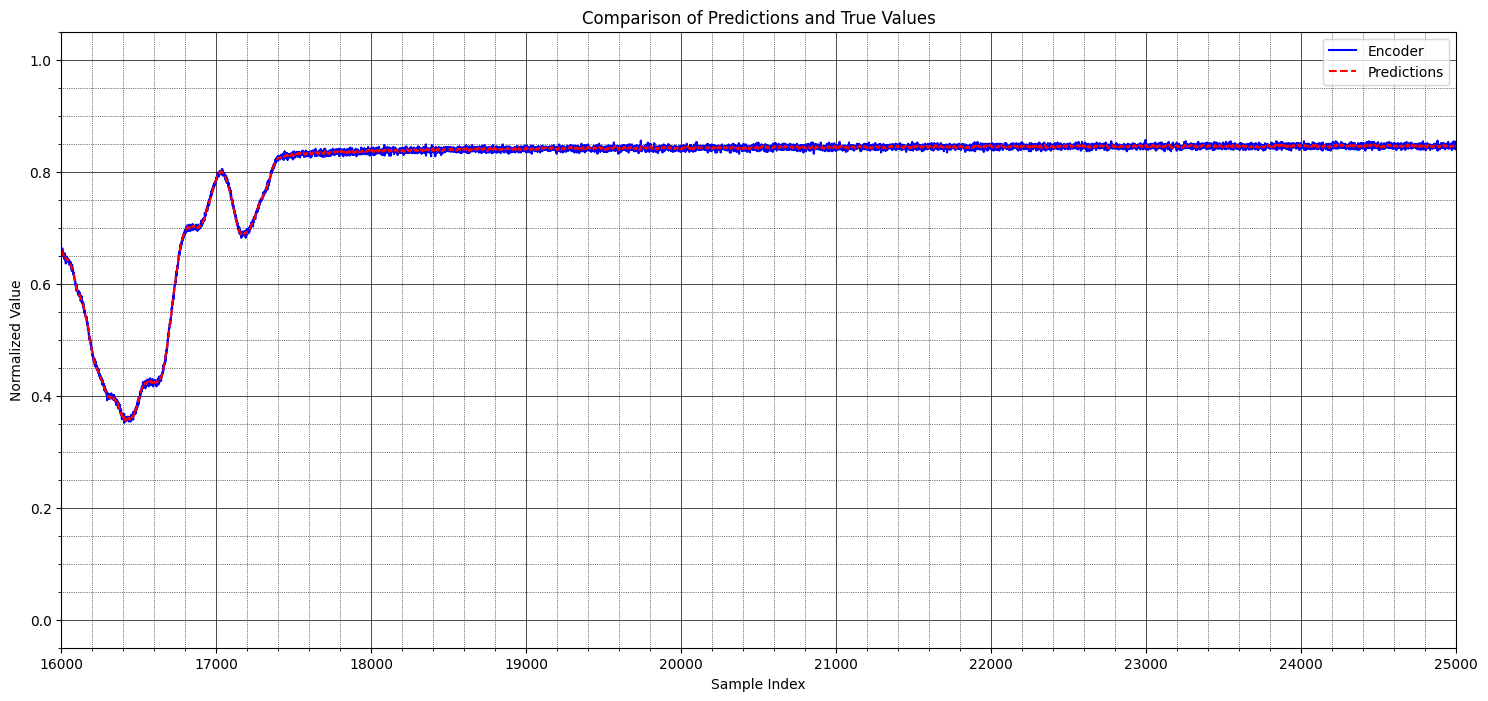

In [22]:
plt.figure(figsize=(18, 8))
plt.plot(y_creep, label='Encoder', color='blue')
plt.plot(predictions, label='Predictions', color='red', linestyle='dashed')
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.xlim(16000, 25000)
#plt.ylim(0, 50)
# create grid with minor ticks on y-axis
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.legend()
plt.show()

#### Convert to formula

In [12]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula_output = model.symbolic_formula()
formula = model.symbolic_formula()[0][0]

fixing (0,0,0) with tan, r2=0.998900294303894
fixing (0,1,0) with abs, r2=0.9972862601280212
fixing (0,2,0) with tan, r2=0.9707743525505066
fixing (0,3,0) with tan, r2=0.7761029601097107
fixing (0,4,0) with tanh, r2=0.99246746301651
fixing (0,5,0) with tanh, r2=0.9996628761291504
fixing (1,0,0) with tanh, r2=0.9996347427368164


In [14]:
formula

2.53*tanh(-0.09*tanh(0.46*x_5 + 0.64) + 1.31*tanh(0.37*x_6 - 0.45) + 0.68) - 0.17

In [4]:
variables = sp.symbols('x1 x2 x3 x4 x5 x6')
# 2.53*tanh(-0.09*tanh(0.46*x_5 + 0.64) + 1.31*tanh(0.37*x_6 - 0.45) + 0.68) - 0.17

formula = 2.53*sp.tanh(-0.09*sp.tanh(0.46*variables[4] + 0.64) + 1.31*sp.tanh(0.37*variables[5] - 0.45) + 0.68) - 0.17

In [5]:
def sympy_to_numpy_lambda(formula, variables):
    """
    Convert a sympy expression to a numpy-compatible lambda function.
    
    Parameters:
    - formula: sympy expression
    - variables: list of sympy symbols representing the variables
    
    Returns:
    - A lambda function that takes numpy arrays as input and evaluates the formula
    """
    # Create a sympy lambda function
    sympy_lambda = sp.lambdify(variables, formula, modules=['numpy'])
    
    # Create a numpy-compatible lambda function
    def numpy_func(X):
        # Ensure X is a numpy array
        X = np.asarray(X)

        # Check that X has the correct shape
        if X.shape[1] != len(variables):
            raise ValueError(f"Input array must have {len(variables)} columns, but got {X.shape[1]} columns.")
        
        # Unpack the columns of X to pass as individual arguments
        return sympy_lambda(*[X[:, i] for i in range(X.shape[1])])
    
    return numpy_func
numpy_formula = sympy_to_numpy_lambda(formula, variables)

In [6]:
# how accurate is this formula?
def acc(formula, X, y):
    return np.mean(np.abs(formula(X) - y.cpu().detach().numpy()))

print('train acc of the formula:', acc(numpy_formula, dataset['train_input'][:30000].cpu(), dataset['train_label'][:30000].cpu()))
print('test acc of the formula:', acc(numpy_formula, dataset['test_input'][:30000].cpu(), dataset['test_label'][:30000].cpu()))

train acc of the formula: 0.3136214
test acc of the formula: 0.30179086


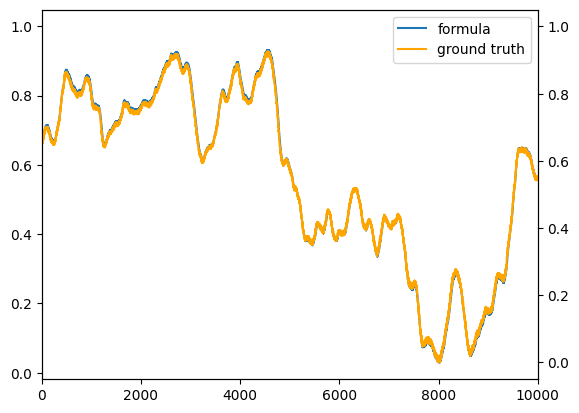

In [7]:
g_truth = dataset['test_label']
output = numpy_formula(dataset['test_input'].cpu().detach().numpy())

fig, ax = plt.subplots()
ax.plot(output, label='formula')
ax2 = ax.twinx()
ax2.plot(g_truth.cpu().detach().numpy(), label='ground truth', color='orange')

# merge legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)

plt.xlim(0, 10000)
plt.show()


In [11]:
outputs = np.array([])
gt = []
mse = 0
for index, row in test_data.loc[:].iterrows():
    if len(outputs) > 17000:
        row['c_mean_lag1'] = outputs[-1]
        row['c_mean_60rmean'] = (row['c_mean_60rmean'] * 60 - row['c_mean'] + outputs[-1]) / 60
        row['c_mean_10rmean'] = (row['c_mean_10rmean'] * 10 - row['c_mean'] + outputs[-1]) / 10
        if len(outputs) > 17004:
            row['c_mean_lag5'] = outputs[-5]
        if len(outputs) > 17009:
            row['c_mean_lag10'] = outputs[-10]
        if len(outputs) > 17049:
            row['c_mean_lag50'] = outputs[-50]
    output = numpy_formula([row[columns_input].values]).astype(np.float64)
    outputs = np.append(outputs, output)
    gt.append(row['c_mean'])

loss = np.mean(np.abs(np.array(outputs) - np.array(gt)))
print(f'MAE: {loss}')

MAE: 0.01522595470979499


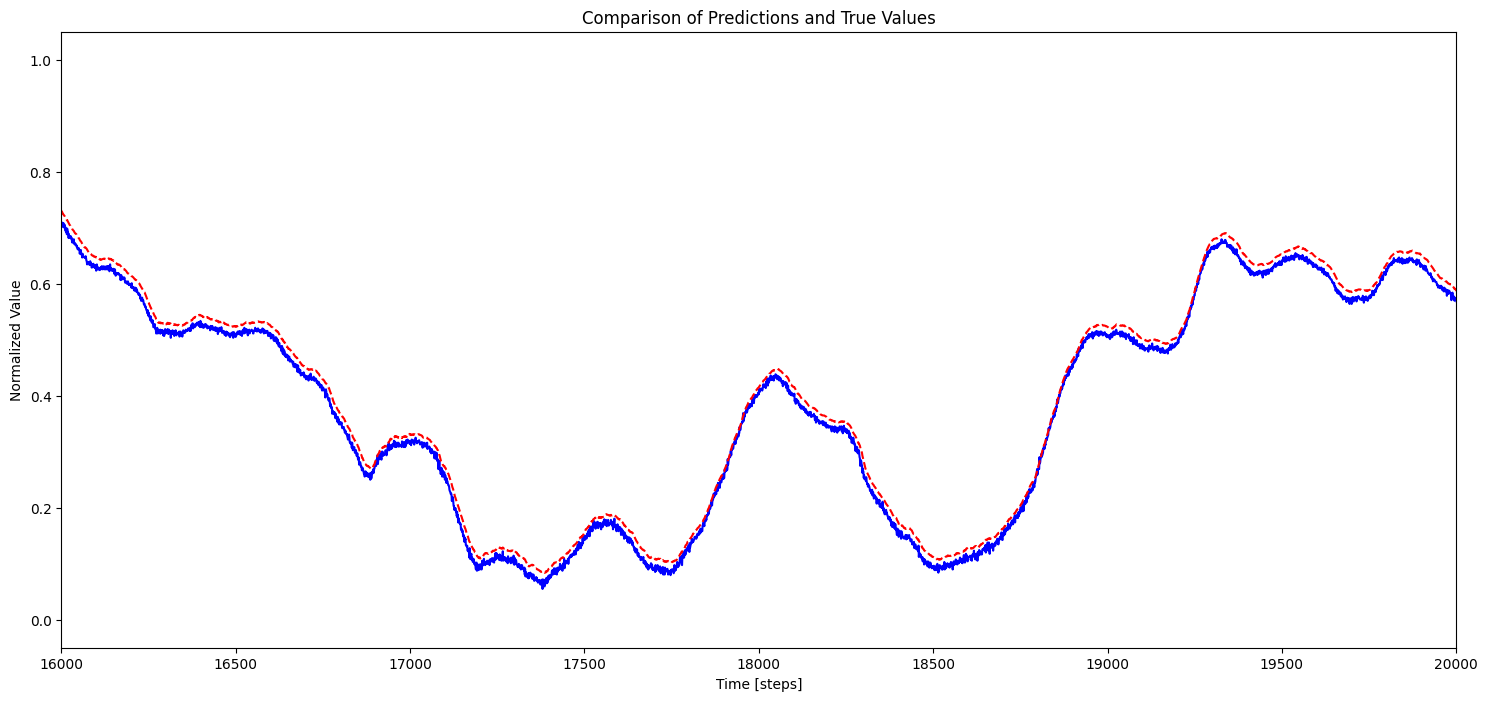

In [10]:
plt.figure(figsize=(18, 8))
plt.plot(gt, label='Encoder', color='blue')
plt.plot(outputs, label='Predictions', color='red', linestyle='dashed')
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Time [steps]')
plt.ylabel('Normalized Value')
plt.xlim(16000, 20000)
plt.show()
